In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

This is a project on predicting whether or not customers will subscribe to a bank term deposit.

This notebook contains the preprocessing and the training part of the project.

The problem and the data is specified on the README.md! 

In [3]:
# Reading the data 
# We need the separator (sep) because of how the data is presented - it is not clean 
df = pd.read_csv(r'C:\Users\User\Desktop\capstone-project\Data\bank-additional-full.csv', sep = ';')
data = df.copy()
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# Datatypes of Variables 
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

## Converting y into numerical
We need to convert our target variable into a numerical column before anything.

In [4]:
data['target'] = (data.y == 'yes').astype(int)
del data['y'] 

In [5]:
# Sorting of variables into numerical and categorical variables
categorical = []
numerical = []

for column in data.columns:
    if data[column].dtype == 'object':
        categorical.append(column)
    else:
        numerical.append(column)

## Correlation with 'target' 

Our target denotes whether or not the client will subscribe to a term deposit at a bank.

In [9]:
correlation = pd.DataFrame(data[numerical].corrwith(data['target']), columns = ['values'])
correlation = correlation.sort_values(by = 'values', ascending = True)
correlation

,values
nr.employed,-0.354678
pdays,-0.324914
euribor3m,-0.307771
emp.var.rate,-0.298334
cons.price.idx,-0.136211
campaign,-0.066357
age,0.030399
cons.conf.idx,0.054878
previous,0.230181
duration,0.405274


Interesting enough, there are quite a few numerical columns with a pretty high correlation, whether it be negative or positive.

The values with the lowest correlation coefficients are campaign, age and cons.conf.idx. Let us just add these values into a list.

In [10]:
lowest_corr_columns = ['campaign', 'age', 'cons.conf.idx']

## Mutual information with 'target' 

Since correlation scores are only with respect to numerical variables, we have to use mutual information for our categorical variables to see the relationship between these categorical variables and the target. 


In [11]:
from sklearn.metrics import mutual_info_score

# Return mutual info score between categorical data and target 
def mutual_info_target_score(series):
    return mutual_info_score(series, data.target)

In [12]:
mi = data[categorical].apply(mutual_info_target_score)

mi.sort_values(ascending=False)

poutcome       0.030384
month          0.026407
contact        0.011646
job            0.009859
default        0.005774
education      0.002390
marital        0.001434
day_of_week    0.000322
housing        0.000069
loan           0.000013
dtype: float64

It would seem that most of our categorical variables are not super related to our target values, but the columns with the lowest number MI scores are day of week, housing, and loan. Let us add these values onto the list we have already made.


In [13]:
lowest_corr_columns.append('day_of_week')
lowest_corr_columns.append('housing')
lowest_corr_columns.append('loan')

## Missing Data

A very essential part of data preprocessing is how many values are missing, and deciding what to do with the missing values themselves. Let's take a look!

In [14]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
target            0
dtype: int64

Clean dataset! Honestly, we don't find this a lot in the real world, but this is still pretty cool :) 

## Duration
Before we continue, we will be deleting "duration". Why? 

To quote from the UCI repository:
'This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.'

We want to have a realistic predictive model, and therefore there we will be deleting this column.

In [6]:
del data['duration']

In [7]:
numerical.remove('duration')

## Categorical columns

Let's take a closer look at our categorical values! 

In [17]:
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

If we refer back to the UCI repository, there are columns that already have values associated to them, and therefore we can use those values! There really isn't much that we can feature engineer from these categorical columns, and therefore we will leave it be.

However, let's see whether we should be encoding these values with a Label Encoderor with a One-Hot Encoder. 

## Difference between a Label Encoder and a One-Hot Encoder

A label encoder associates one value to a number and is suitable for some variables that have more than a number of unique values. This is compares to a One Hot Encoder instead, whereby new variables are created based on whether they have that value or not. This will only change the values of the categorical data, and not the whole dataset.

We will be using the dict vectorizer once we have split the data.

e.g. If we have datapoints ['Amsterdam', 'Paris', 'Amsterdam', 'Berlin'], we will be converting that to [0,1,0,2] using a label encoder. This is compared to a OneHotEncoder where there will be columns "Amsterdam", "Paris" and "Berlin" with either 0/1.

For more information, do read the [Label Encoder documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) for details!

Source: [midterm project](https://github.com/kwangyy/midterm-project/blob/main/code/Midterm%20Project%20for%20MLE%20-%20Training%20Models%20and%20Hyperparameter%20Tuning%20(outputless).ipynb)

In [18]:
for column in categorical:
    print(column, data[column].nunique())

job 12
marital 4
education 8
default 3
housing 3
loan 3
contact 2
month 10
day_of_week 5
poutcome 3


Personally, I will use One-Hot Encoder if there are less than 15 values. 
Since the categorical columns have less than 15 unique columns, we can just do normal one hot encoding on these categorical columns. We will be using a Dict Vectorizer to do One Hot Encoding. 

## Visualising Numerical Data

Let us start with visualising numerical data!


In [19]:
numerical

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'target']

In [20]:
for column in numerical:
    print(column, data[column].std())

age 10.421249980934048
campaign 2.7700135429023276
pdays 186.9109073447418
previous 0.4949010798392897
emp.var.rate 1.5709597405170255
cons.price.idx 0.5788400489541262
cons.conf.idx 4.628197856174544
euribor3m 1.734447404851267
nr.employed 72.25152766826108
target 0.3161734269429649


There are two columns with a rather high standard deviation, namely nr.employed and age (although cons.conf.idx is pretty high as well).

Let's take a deeper look at the visualisations for each numerical data!

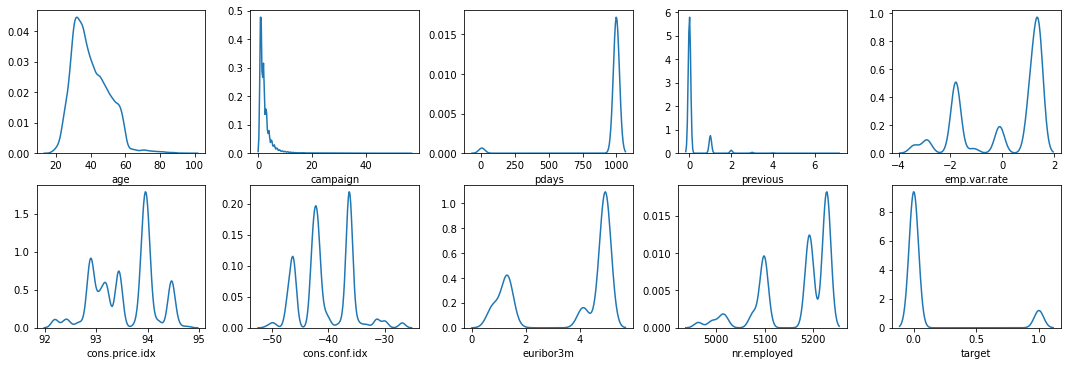

In [21]:
fig, axes = plt.subplots(2, 5, figsize = (15, 5))
plt.tight_layout()

for number, column in enumerate(numerical):
    if number < 5:
        # First 5 columns
        plot = sns.kdeplot(x=column, data=data, ax = axes[0][number])
        # We set label as blank
        plot.set(ylabel = '')
    else:
        # We can't reset the count if we use this approach, therefore we minus 5 off
        plot = sns.kdeplot(x=column, data=data, ax = axes[1][number-5])
        plot.set(ylabel = '')

There are a few things that we can tell from this data:
1. Campaign has a very long tail, and therefore we should transform it with transformations
2. Some of the data have multiple peaks - let's see if we should do anything to them. 


## Visualising Categorical Data

Let us continue with visualising categorical data.

In [22]:
categorical_plot = categorical.copy()
categorical_plot.remove('job')
categorical_plot.remove ('education')

big_plots = ['job', 'education']

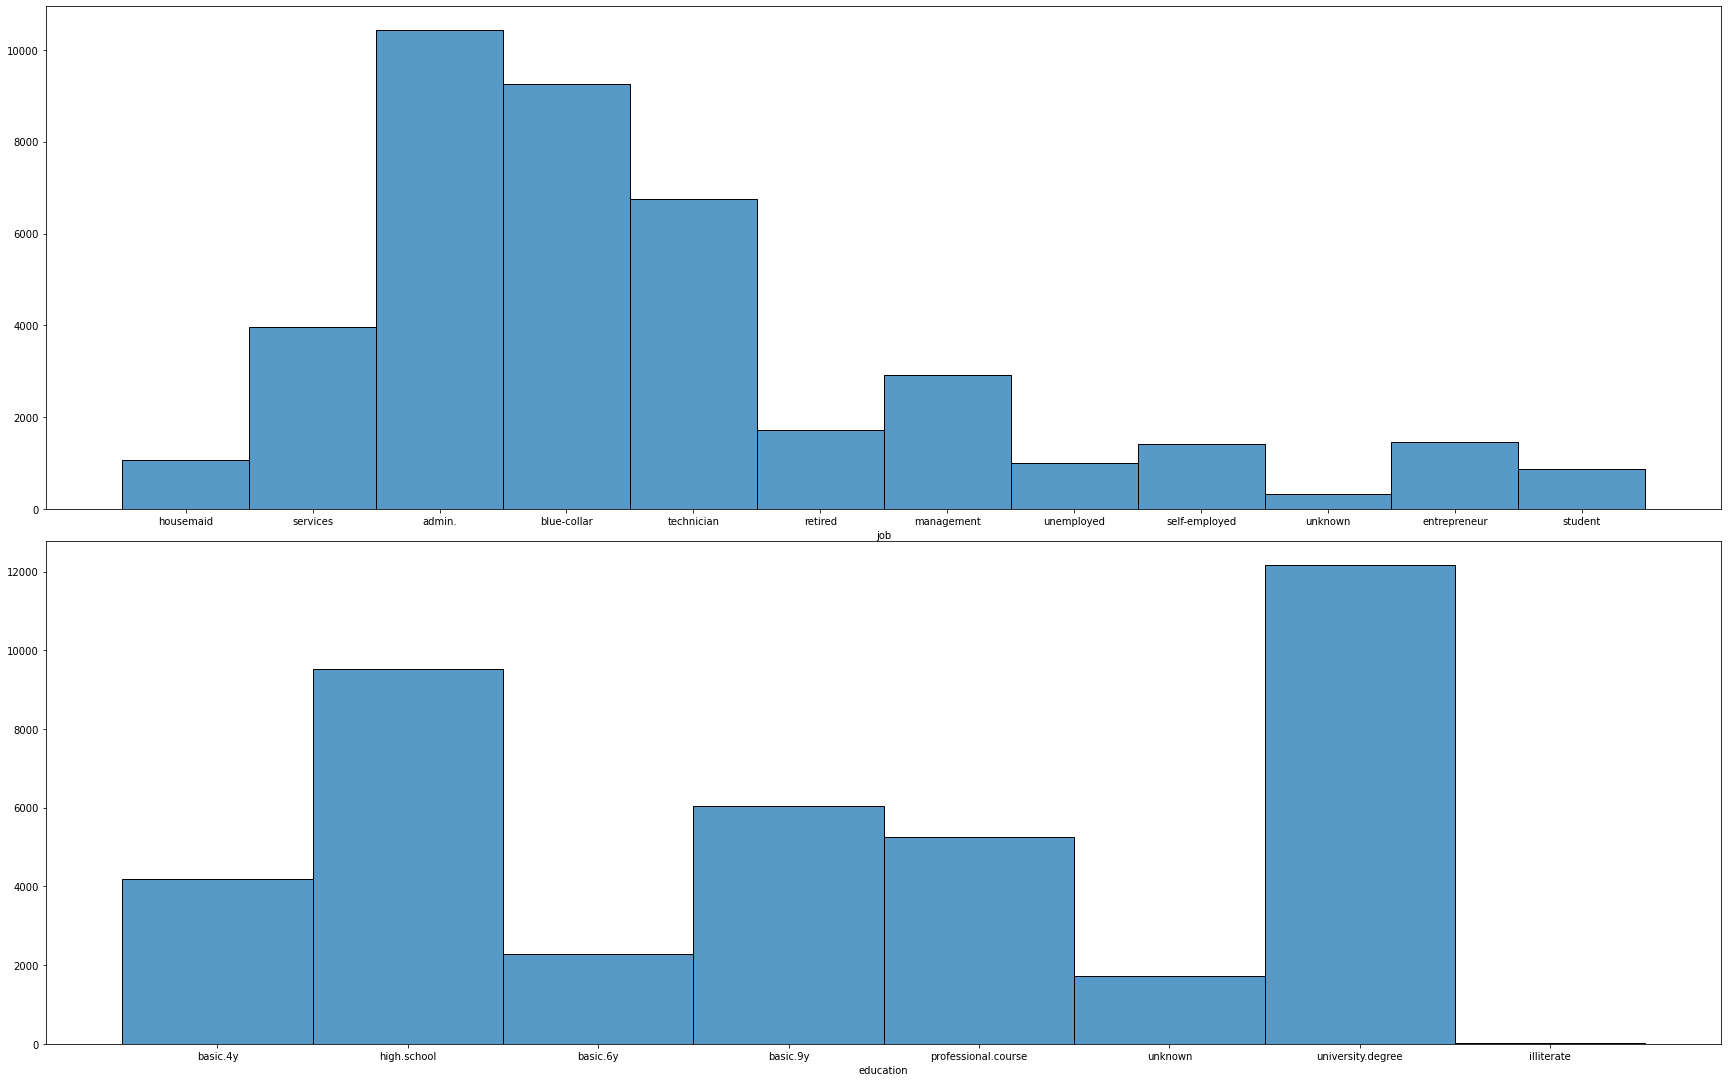

In [23]:
fig, axes = plt.subplots(2, 1, figsize = (24,15))
plt.tight_layout()

for number, column in enumerate(big_plots):
    plot = sns.histplot(x=column, data=data, ax = axes[number])
    plot.set(ylabel = '')


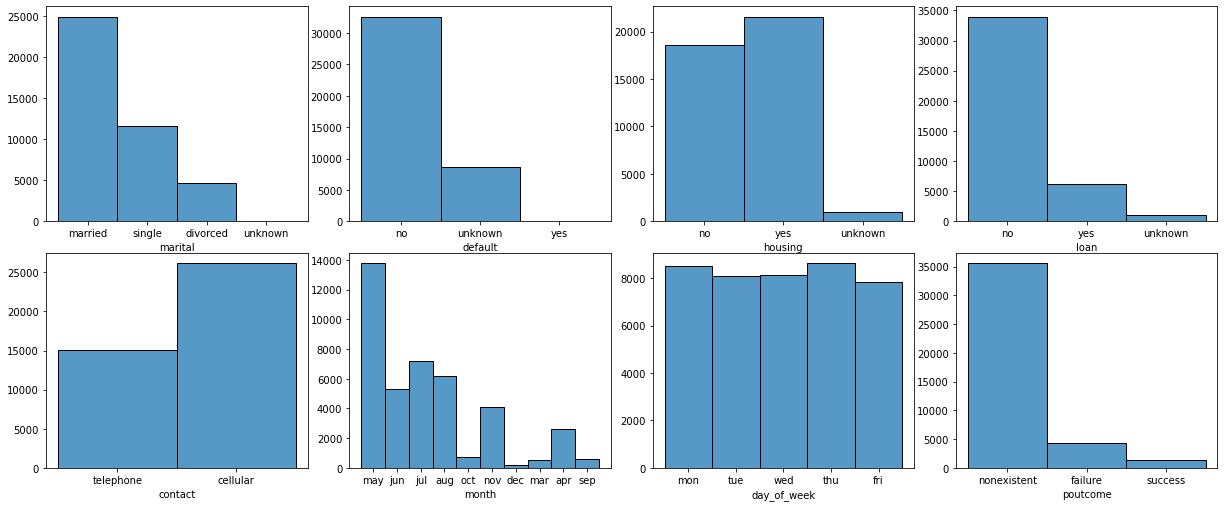

In [24]:
fig, axes = plt.subplots(2, 4, figsize = (17,7))
plt.tight_layout()

for number, column in enumerate(categorical_plot):
    if number < 4:
        plot = sns.histplot(x=column, data=data, ax = axes[0][number])
        plot.set(ylabel = '')
    else:
        plot = sns.histplot(x=column, data=data, ax = axes[1][number- 4])
        plot.set(ylabel = '')

## A deeper look into our target variable 

It seems that our target variable is rather imbalanced, let's take a closer look at it!

In [25]:
data['target'].value_counts(normalize = True)

0    0.887346
1    0.112654
Name: target, dtype: float64

We can tell that our target variable is very imbalanced - 88.7% of our target is no, while 11.3% of our target is yes. Therefore, accuracy will probably be a very bad metric to use. 

Instead, we will have to use the ROC AUC score, whereby it considers both the precision and the recall of the model itself for a better gauge. 

<AxesSubplot:>

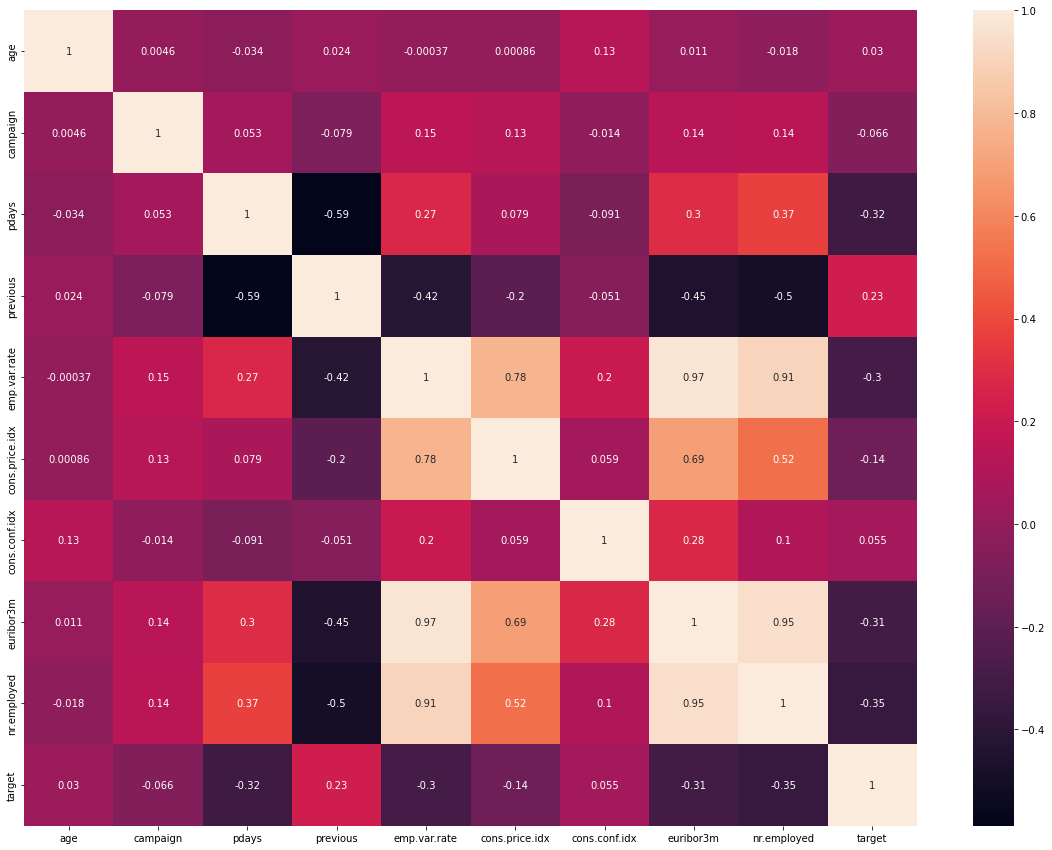

In [26]:
fig = plt.figure(figsize = (20,15))
sns.heatmap(data[numerical].corr(), annot = True)

In [27]:
import warnings
warnings.filterwarnings('ignore')

## Train Test Split of the Data

I will be splitting the dataset into 60% / 20% / 20% in terms of the training dataset, the validation dataset, and the test dataset. 

There is 'stratify' parameter in the data itself, which ensures that the data follows the proportion of 0s and 1s.

In [8]:
from sklearn.model_selection import train_test_split
data_full_train, data_test = train_test_split(data, random_state = 40, test_size = 0.2, shuffle = True, stratify = data['target'])
data_train, data_val = train_test_split(data_full_train, random_state = 40, test_size = 0.25, shuffle = True, stratify = data_full_train['target'])

In [29]:
data_train['target'].value_counts(normalize = True)

0    0.887342
1    0.112658
Name: target, dtype: float64

In [30]:
data_val['target'].value_counts(normalize = True)

0    0.887351
1    0.112649
Name: target, dtype: float64

In [31]:
data_test['target'].value_counts(normalize = True)

0    0.887351
1    0.112649
Name: target, dtype: float64

We can tell that the proportion of data remains the same here! 

In [32]:
data_train = data_train.reset_index(drop = True)
data_val = data_val.reset_index(drop = True)
data_test = data_test.reset_index(drop = True)

In [33]:
y_train = data_train['target']
y_val = data_val['target']
y_test = data_test['target']

del data_train['target']
del data_val['target']
del data_test['target']

## Training the models - without scalers
We will be training the data on a few different regression models and judging the models based on the ROC AUC score.

We will be looking for the best regression model without any form of hyperparameter tuning, and using cross-validation to better judge the results. 

In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

In [35]:
# Training function
def train(data_train, y_train, model): 
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model.fit(X_train, y_train)
    return dv, model


In [36]:
def predict(data_val, y_val, model):
    dicts = data_val.to_dict(orient = 'records')
    
    X_val = dv.transform(dicts)
    
    y_pred = model.predict_proba(X_val)[:,1]
    return y_pred

## Logistic Regression 

This will be out baseline model for our predictions, in order to see how our other models go against this baseline model.

In [37]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
mean_scores = []
std_scores = []

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

In [39]:
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score 
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, logreg)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))
    
print('ROC AUC score for model %s: %.5f +- %.5f' % (model, np.mean(scores), np.std(scores)))

ROC AUC score for model LogisticRegression(): 0.76936 +- 0.01973


## Random Forest Classifier

We have learnt about Random Forests back in Lesson 6 of the Machine Learning Zoomcamp!

In [40]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

In [41]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, rfc)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % (model, np.mean(scores), np.std(scores)))

ROC AUC score for model RandomForestClassifier(): 0.76955 +- 0.00757


## XGBoost Classifier

We have learnt this Classifier back in Lesson 6 of the Machine Learning Zoomcamp!

In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(verbosity = 0)

In [43]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, xgb)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('XGBClassifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model XGBClassifier: 0.78539 +- 0.00721


## CatBoost Classifier

CatBoost is another gradient boosting tool that we can use for classification. It is faster and better performing than other gradient boosting algorithms. 

In [44]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(logging_level ='Silent')

In [45]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, cbc)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('CatBoostClassifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model CatBoostClassifier: 0.79739 +- 0.00769


In [46]:
d = {'models': models, 'mean': mean_scores, 'std':std_scores}
df = pd.DataFrame(data = d)

In [47]:
df

,models,mean,std
0,Logistic Regression,0.769356,0.019732
1,Random Forest,0.769548,0.007565
2,XGBoost,0.785389,0.007205
3,CatBoost,0.797391,0.007694


# Training models - with scalers 
Let us use scalers on the dataset!

There are two scalers that we can use: 
1. StandardScaler
2. MinMaxScaler

Let us start with the Standard Scaler and see how the results differ from there!

In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
# For any scores later
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
mean_scores = []
std_scores = []

## Logistic Regression (with scaling) 

In [50]:
model = LogisticRegression()

In [51]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Logistic Regression' , np.mean(scores), np.std(scores)))

ROC AUC score for model Logistic Regression: 0.78994 +- 0.01139


## Random Forest Classifier - with scaling 

In [52]:
model = RandomForestClassifier()

In [53]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Random Forest Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model Random Forest Classifier: 0.77071 +- 0.00877


## XGB Classifier - with scaling

In [54]:
model = XGBClassifier()

In [55]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('XGB Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model XGB Classifier: 0.78539 +- 0.00722


## CatBoost Classifier - with scaling

In [56]:
model = CatBoostClassifier(logging_level ='Silent')

In [57]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Cat Boost Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model Cat Boost Classifier: 0.79739 +- 0.00769


In [58]:
d = {'models': models, 'mean': mean_scores, 'std':std_scores}
df_2 = pd.DataFrame(data = d)

In [59]:
df

,models,mean,std
0,Logistic Regression,0.769356,0.019732
1,Random Forest,0.769548,0.007565
2,XGBoost,0.785389,0.007205
3,CatBoost,0.797391,0.007694


We can tell that Catboost, yet again, provides us with the best ROC AUC score out of all of them. It should be noted that the Random Forest algorithm and the XGBoost algorithm actually does worse than the logistic regression model as well, which is surprising!

## Training models - with minmax scaling

Now, let's use minmax scaling to train our models.

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
mean_scores = []
std_scores = []

## Logistic Regression - with minmax scaling 

In [62]:
model = LogisticRegression()

In [63]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Logistic Regression' , np.mean(scores), np.std(scores)))

ROC AUC score for model Logistic Regression: 0.79005 +- 0.01127


## Random Forest Classifier - with minmax scaling  

In [64]:
model = RandomForestClassifier()

In [65]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Random Forest Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model Random Forest Classifier: 0.77101 +- 0.00732


## XGB Classifier - with minmax scaling  

In [66]:
model = XGBClassifier()

In [67]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('XGB Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model XGB Classifier: 0.78540 +- 0.00721


## CatBoost Classifier - with minmax scaling 

In [68]:
model = CatBoostClassifier(logging_level ='Silent')

In [69]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_full_train.iloc[train_idx]
    data_val = data_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('CatBoost Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model CatBoost Classifier: 0.79739 +- 0.00769


In [70]:
d = {'models': models, 'mean': mean_scores, 'std':std_scores}
df_3 = pd.DataFrame(data = d)

In [71]:
df

,models,mean,std
0,Logistic Regression,0.769356,0.019732
1,Random Forest,0.769548,0.007565
2,XGBoost,0.785389,0.007205
3,CatBoost,0.797391,0.007694


In [72]:
for column in df_2.columns:
    df_2[str(column + "_2")] = df_2[column]
    del df_2[column]


In [73]:
df_2['models'] = df_2['models_2']
del df_2['models_2']

In [74]:
for column in df_3.columns:
    df_3[str(column + "_3")] = df_3[column]
    del df_3[column]

In [75]:
df_3['models'] = df_3['models_3']
del df_3['models_3']

In [76]:
df_full = df.merge(df_2, how = 'left').merge(df_3, how = 'left')

In [77]:
df_full['standard_mean_change'] = ((df_full['mean_2'] - df_full['mean'])/df_full['mean']) * 100
df_full['minmax_mean_change'] = ((df_full['mean_3'] - df_full['mean'])/df_full['mean']) * 100

df_full['standard_std_change']= -((df_full['std_2'] - df_full['std'])/df_full['std']) * 100
df_full['minmax_std_change']= -((df_full['std_3'] - df_full['std'])/df_full['std']) * 100

In [78]:
df_full

,models,mean,std,mean_2,std_2,mean_3,std_3,standard_mean_change,minmax_mean_change,standard_std_change,minmax_std_change
0,Logistic Regression,0.769356,0.019732,0.789944,0.011390,0.790054,0.011273,2.675957,2.690306,42.277641,42.868649
1,Random Forest,0.769548,0.007565,0.770709,0.008770,0.771010,0.007317,0.150854,0.190025,-15.927614,3.280079
2,XGBoost,0.785389,0.007205,0.785387,0.007222,0.785396,0.007208,-0.000289,0.000797,-0.229369,-0.030310
3,CatBoost,0.797391,0.007694,0.797391,0.007694,0.797391,0.007694,-0.000011,-0.000011,0.001065,0.001065


In [79]:
df_mean = df_full[['mean', 'mean_2', 'mean_3']]

In [80]:
df_mean.max()

mean      0.797391
mean_2    0.797391
mean_3    0.797391
dtype: float64

## Analysis of ROC score 

Some things to clarify:
- All of these changes are in terms of percentage.
- Positive changes denote an improvement, and negative changes denote a deterioration of results

Generally, CatBoost has the highest score out of the four models that are measured.

Some interesting observations:
- The ROC score for the Logistic Regression increases with both the Standard Scaler and the MinMax Scaler, and decreases for the CatBoost Classifier.
- The ROC score for both the Random Forest Classifier and the XGBoost Classifier will increase or decrease, depending on the Scaler. 
- There is a big improvement in the standard deviation of the Logistic Regression model when the scalers are used. There is a huge deterioration, however, with the Random Forest model especially with the MinMax scaler.
- CatBoost Classifier has a pretty constant mean ROC AUC score, so we can say that it is pretty constant even with the scalers

## Trying a smaller model

What if we use a smaller model to train our model instead? If you recall, we had a 'lowest_corr_columns' list of columns. What if we remove these variables from our dataset? 

Let's try training with the smaller dataset!

In [81]:
data_columns = []
for column in data.columns:
    data_columns.append(column)
for column in lowest_corr_columns:
    data_columns.remove(column)

In [82]:
data_columns

['job',
 'marital',
 'education',
 'default',
 'contact',
 'month',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'euribor3m',
 'nr.employed',
 'target']

In [83]:
data_full_train, data_test = train_test_split(data, random_state = 40, test_size = 0.2, shuffle = True, stratify = data['target'])
data_train, data_val = train_test_split(data_full_train, random_state = 40, test_size = 0.25, shuffle = True, stratify = data_full_train['target'])

In [84]:
data_small_full_train = data_full_train[data_columns]
data_small_full_train.reset_index()

,index,job,marital,education,default,contact,month,pdays,previous,poutcome,emp.var.rate,cons.price.idx,euribor3m,nr.employed,target
0,17194,admin.,single,high.school,no,telephone,jul,999,0,nonexistent,1.4,93.918,4.962,5228.1,0
1,3239,admin.,married,university.degree,no,telephone,may,999,0,nonexistent,1.1,93.994,4.860,5191.0,0
2,30931,blue-collar,married,basic.9y,no,cellular,may,999,0,nonexistent,-1.8,92.893,1.344,5099.1,0
3,25274,services,married,basic.9y,no,cellular,nov,4,1,success,-0.1,93.200,4.153,5195.8,0
4,38400,housemaid,married,basic.4y,no,cellular,oct,6,1,success,-3.4,92.431,0.737,5017.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,28809,technician,single,high.school,no,telephone,apr,999,2,failure,-1.8,93.075,1.410,5099.1,0
32946,7807,entrepreneur,married,basic.4y,no,telephone,jun,999,0,nonexistent,1.4,94.465,4.865,5228.1,0
32947,29220,housemaid,divorced,high.school,unknown,cellular,apr,999,0,nonexistent,-1.8,93.075,1.405,5099.1,0
32948,30527,admin.,married,professional.course,no,cellular,may,999,0,nonexistent,-1.8,92.893,1.354,5099.1,0


In [85]:
data_small_train = data_train[data_columns]
data_small_train.reset_index()

y_small_train = data_small_train['target']
del data_small_train['target']

In [86]:
data_small_val = data_val[data_columns]
data_small_val.reset_index()

y_small_val = data_small_val['target']
del data_small_val['target']

## Using smaller dataset

In [87]:
def train(data_train, y_train, model): 
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model.fit(X_train, y_train)
    return dv, model


In [88]:
def predict(data_val, y_val, model):
    dicts = data_val.to_dict(orient = 'records')
    
    X_val = dv.transform(dicts)
    
    y_pred = model.predict_proba(X_val)[:,1]
    return y_pred

In [89]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
mean_scores = []
std_scores = []

## Logistic Regression - with smaller dataset

In [90]:
logreg = LogisticRegression()

In [91]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, logreg)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Logistic Regression' , np.mean(scores), np.std(scores)))

ROC AUC score for model Logistic Regression: 0.78670 +- 0.01076


## Random Forest Classifier - with smaller dataset 

In [92]:
rfc = RandomForestClassifier()

In [93]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, rfc)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Random Forest Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model Random Forest Classifier: 0.74819 +- 0.00976


## XGB Classifier - with smaller dataset

In [94]:
xgb = XGBClassifier()

In [95]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, xgb)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('XGB Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model XGB Classifier: 0.78812 +- 0.00636


## CatBoost Classifier - with smaller dataset 

In [96]:
cbc = CatBoostClassifier(logging_level ='Silent')

In [97]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dv, model = train(data_train, y_train, cbc)
    y_pred = predict(data_val, dv, model)
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('CatBoost Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model CatBoost Classifier: 0.79523 +- 0.01040


In [98]:
d = {'models': models, 'mean_small': mean_scores, 'std_small':std_scores}
df_small = pd.DataFrame(data = d)

In [99]:
df_small

,models,mean_small,std_small
0,Logistic Regression,0.786700,0.010758
1,Random Forest,0.748187,0.009758
2,XGBoost,0.788116,0.006355
3,CatBoost,0.795235,0.010404


In [100]:
df_small_comparison = df.merge(df_small, how = 'left')

In [101]:
df_small_comparison

,models,mean,std,mean_small,std_small
0,Logistic Regression,0.769356,0.019732,0.786700,0.010758
1,Random Forest,0.769548,0.007565,0.748187,0.009758
2,XGBoost,0.785389,0.007205,0.788116,0.006355
3,CatBoost,0.797391,0.007694,0.795235,0.010404


In [102]:
df_small_comparison['mean_change'] = (df_small_comparison['mean_small'] - df_small_comparison['mean'])/df_small_comparison['mean'] * 100

df_small_comparison['std_change'] = -(df_small_comparison['std_small'] - df_small_comparison['std'])/df_small_comparison['std'] * 100

In [103]:
df_small_comparison

,models,mean,std,mean_small,std_small,mean_change,std_change
0,Logistic Regression,0.769356,0.019732,0.786700,0.010758,2.254307,45.476529
1,Random Forest,0.769548,0.007565,0.748187,0.009758,-2.775810,-28.985071
2,XGBoost,0.785389,0.007205,0.788116,0.006355,0.347116,11.797092
3,CatBoost,0.797391,0.007694,0.795235,0.010404,-0.270369,-35.220620


## Analysis of ROC score 

Some things to clarify:
- All of these changes are in terms of percentage.
- Positive changes denote an improvement, and negative changes denote a deterioration of results

Generally, the CatBoost still does the best out of all the models, and the ROC AUC score actually deteriorates with the change in the size of the dataset. 

Some interesting observations:
- Logistic Regression and XGBoost has improved ROC AUC performance with the smaller dataset, while Random Forest and CatBoost has decreased performance. 
- There is a pretty big change in the standard deviation with the smaller dataset. Logistic Regression and XGBoost decreases the standard deviation, while RandomForest and CatBoost increases the standard deviation.

## Models + Smaller Dataset + Standard Scaler

We will be combining the both the smaller dataset and the scalers together to see the changes with the ROC AUC score.

In [104]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
mean_scores = []
std_scores = []

## Logistic Regression - smaller dataset + standard scaler 

In [105]:
model = LogisticRegression()

In [106]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Logistic Regression' , np.mean(scores), np.std(scores)))

ROC AUC score for model Logistic Regression: 0.78865 +- 0.01065


## Random Forest Classifier - smaller dataset + standard scaler 

In [107]:
model = RandomForestClassifier()

In [108]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Random Forest Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model Random Forest Classifier: 0.74901 +- 0.01152


## XGB Classifier - smaller dataset + standard scaler 

In [109]:
model = XGBClassifier()

In [110]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('XGB Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model XGB Classifier: 0.78813 +- 0.00637


## CatBoost Classifier - smaller dataset + standard scaler 

In [111]:
model = CatBoostClassifier(logging_level = 'Silent')

In [112]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('CatBoost Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model CatBoost Classifier: 0.79523 +- 0.01040


In [113]:
d = {'models': models, 'mean_small': mean_scores, 'std_small':std_scores}
df_small_2 = pd.DataFrame(data = d)

In [114]:
for column in df_small_2.columns:
    df_small_2[str(column + "_2")] = df_small_2[column]
    del df_small_2[column]

In [115]:
df_small_2['models'] = df_small_2['models_2']
del df_small_2['models_2']

## Models + Smaller Dataset + Min Max Scaler

In [116]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost']
mean_scores = []
std_scores = []

## Logistic Regression - smaller dataset + minmax scaler 

In [117]:
model = LogisticRegression()

In [118]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Logistic Regression' , np.mean(scores), np.std(scores)))

ROC AUC score for model Logistic Regression: 0.78869 +- 0.01086


## Random Forest Classifier - smaller dataset + minmax scaler 

In [119]:
model = RandomForestClassifier()

In [120]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('Random Forest Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model Random Forest Classifier: 0.74859 +- 0.01148


## XGB Classifier - smaller dataset + minmax scaler 

In [121]:
model = XGBClassifier()

In [122]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('XGB Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model XGB Classifier: 0.78812 +- 0.00636


## CatBoost Classifier - smaller dataset + minmax scaler 

In [123]:
model = CatBoostClassifier(logging_level = 'Silent')

In [124]:
n_splits = 5
scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
for train_idx, val_idx in kfold.split(data_full_train):
    # data splitting
    data_train = data_small_full_train.iloc[train_idx]
    data_val = data_small_full_train.iloc[val_idx]
        
    # y values
    y_train = data_train['target']
    y_val = data_val['target']
    
    del data_train['target']
    del data_val['target']
        
    # training and predicting
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    inter_train = dv.fit_transform(dicts)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(inter_train)
    
    model.fit(X_train, y_train)
    
    dicts = data_val.to_dict(orient = 'records')
    
    inter_val = dv.transform(dicts)
    X_val = scaler.transform(inter_val)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
    
mean_scores.append(np.mean(scores))
std_scores.append(np.std(scores))

print('ROC AUC score for model %s: %.5f +- %.5f' % ('CatBoost Classifier' , np.mean(scores), np.std(scores)))

ROC AUC score for model CatBoost Classifier: 0.79523 +- 0.01040


In [125]:
d = {'models': models, 'mean_small': mean_scores, 'std_small':std_scores}
df_small_3 = pd.DataFrame(data = d)

In [126]:
for column in df_small_3.columns:
    df_small_3[str(column + "_3")] = df_small_3[column]
    del df_small_3[column]

In [127]:
df_small_3['models'] = df_small_3['models_3']
del df_small_3['models_3']

In [128]:
df_small_full = df.merge(df_small_2, how = 'left').merge(df_small_3, how = 'left')

In [129]:
df_small_full['standard_mean_change'] = ((df_small_full['mean_small_2'] - df_small_full['mean'])/df_small_full['mean']) * 100
df_small_full['minmax_mean_change'] = ((df_small_full['mean_small_3'] - df_small_full['mean'])/df_small_full['mean']) * 100

df_small_full['standard_std_change']= -((df_small_full['std_small_2'] - df_small_full['std'])/df_small_full['std']) * 100
df_small_full['minmax_std_change']= -((df_small_full['std_small_3'] - df_small_full['std'])/df_small_full['std']) * 100

In [130]:
df_small_full

,models,mean,std,mean_small_2,std_small_2,mean_small_3,std_small_3,standard_mean_change,minmax_mean_change,standard_std_change,minmax_std_change
0,Logistic Regression,0.769356,0.019732,0.788651,0.010654,0.788685,0.010858,2.507958,2.512372,46.005491,44.970834
1,Random Forest,0.769548,0.007565,0.749005,0.011515,0.748592,0.011477,-2.669472,-2.723158,-52.211344,-51.710317
2,XGBoost,0.785389,0.007205,0.788129,0.006375,0.788123,0.006361,0.348765,0.348027,11.527175,11.715247
3,CatBoost,0.797391,0.007694,0.795234,0.010403,0.795234,0.010403,-0.270494,-0.270494,-35.207682,-35.207682


## Analysis of ROC score 

Some things to clarify:
- All of these changes are in terms of percentage.
- Positive changes denote an improvement, and negative changes denote a deterioration of results

Generally, the CatBoost still does the best out of all the models, and the ROC AUC score actually deteriorates with the change in the size of the dataset as well as the addition of the scalers.

Some interesting observations:
- Logistic Regression and XGBoost have improved ROC AUC performances with the smaller dataset + scalers, while Random Forest and CatBoost have decreased performance. 
- There is a pretty big change in the standard deviation with the smaller dataset. Logistic Regression and XGBoost decreases the standard deviation, while RandomForest and CatBoost increases the standard deviation.

## First round of testing:
- It would seem that CatBoost does the best throughout. 
- Random Forest Classifier seems to do rather well with the initial dataset, however with scalers or with a smaller dataset it does significantly worse than other models. 


## Hyperparameter Tuning - Optuna 

We have done hyperparamater tuning before manually, and we have done hyperparameter tuning using GridSearchCV and RandomizedSearchCV. Is there any other way whereby we are able to tune our hyperparameters? 

There is! There is a library called Optuna that allows for automated hyperparameter optimization that we can use for our hyperparameter tuning.

To fully use optuna, this is what we we do: 

1. We have to define an 'objective' function
2. We use the 'trial' model to define hyperparameters.
3. Make the study and let Optuna optimize 
4. Check the best hyperparameters from there! 

This is the simplest way to use Optuna. There are other things that we can do with Optuna, such as pruning unpromising trials, but let's not complicate the hyperparameter tuning! 

In [131]:
import optuna
import optuna.trial as trial

In [132]:
from sklearn.metrics import roc_auc_score 

In [133]:
from sklearn.model_selection import train_test_split
data_full_train, data_test = train_test_split(data, random_state = 40, test_size = 0.2, shuffle = True, stratify = data['target'])
data_train, data_val = train_test_split(data_full_train, random_state = 40, test_size = 0.25, shuffle = True, stratify = data_full_train['target'])

data_train = data_train.reset_index(drop = True)
data_val = data_val.reset_index(drop = True)
data_test = data_test.reset_index(drop = True)

y_train = data_train['target']
y_val = data_val['target']
y_test = data_test['target']

del data_train['target']
del data_val['target']
del data_test['target']

In [134]:
dicts = data_train.to_dict(orient = 'records')
    
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(dicts)
    
dicts = data_val.to_dict(orient = 'records')
    
X_val = dv.transform(dicts)

## Optuna Study for Logistic Regression

In [135]:
# 1: defining objective.

def objective_logreg(trial):
    params = {
    # 2: define hyper parameters:
    'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    
    'tol': trial.suggest_float('tol', 1e-4, 1),
    
    'C': trial.suggest_float("C", 1e-10, 1e10, log=True),
    
    'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    
    'max_iter': trial.suggest_float('max_iter', 10, 1e9),
    }

    model = LogisticRegression(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    return score 

In [136]:
# 3 Make the study, and let Optuna optimize
# Will be using function

def study_model(function):
    study = optuna.create_study(direction = 'maximize')
    study.optimize(function, n_trials = 200)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    return study.best_trial.params

In [137]:
logreg_params = study_model(objective_logreg)

[I 2021-12-06 11:05:33,768] A new study created in memory with name: no-name-4e54044c-41e4-48f8-a528-144975162eb6
[I 2021-12-06 11:05:33,854] Trial 0 finished with value: 0.621290508986273 and parameters: {'solver': 'lbfgs', 'tol': 0.559317696733038, 'C': 7.375304809780011e-07, 'fit_intercept': False, 'max_iter': 754798908.6376958}. Best is trial 0 with value: 0.621290508986273.
[I 2021-12-06 11:05:33,894] Trial 1 finished with value: 0.5652331772725128 and parameters: {'solver': 'saga', 'tol': 0.5608769922354468, 'C': 116286.95090122847, 'fit_intercept': False, 'max_iter': 139324671.6016759}. Best is trial 0 with value: 0.621290508986273.
[I 2021-12-06 11:05:33,933] Trial 2 finished with value: 0.5131761816595123 and parameters: {'solver': 'saga', 'tol': 0.5926498614344234, 'C': 1.0506190328135172, 'fit_intercept': True, 'max_iter': 402328661.6835141}. Best is trial 0 with value: 0.621290508986273.
[I 2021-12-06 11:05:35,015] Trial 3 finished with value: 0.7524404158215011 and paramet

[I 2021-12-06 11:06:06,959] Trial 29 finished with value: 0.7596598011698664 and parameters: {'solver': 'liblinear', 'tol': 0.6547973428301568, 'C': 7418.16499164748, 'fit_intercept': False, 'max_iter': 733775521.4928569}. Best is trial 28 with value: 0.7818714915797915.
[I 2021-12-06 11:06:09,129] Trial 30 finished with value: 0.7812539801405727 and parameters: {'solver': 'newton-cg', 'tol': 0.521707522969499, 'C': 108471.49975956393, 'fit_intercept': False, 'max_iter': 435851286.37762165}. Best is trial 28 with value: 0.7818714915797915.
[I 2021-12-06 11:06:11,268] Trial 31 finished with value: 0.7812277406953158 and parameters: {'solver': 'newton-cg', 'tol': 0.8391320192903606, 'C': 24.613376923406946, 'fit_intercept': False, 'max_iter': 842747972.0488926}. Best is trial 28 with value: 0.7818714915797915.
[I 2021-12-06 11:06:12,870] Trial 32 finished with value: 0.7813966755507336 and parameters: {'solver': 'newton-cg', 'tol': 0.9205238936439443, 'C': 0.16300858448094238, 'fit_inter

[I 2021-12-06 11:06:44,719] Trial 58 finished with value: 0.7813517147035238 and parameters: {'solver': 'newton-cg', 'tol': 0.7611854713101491, 'C': 0.11317400026810032, 'fit_intercept': False, 'max_iter': 143665838.37743264}. Best is trial 28 with value: 0.7818714915797915.
[I 2021-12-06 11:06:46,901] Trial 59 finished with value: 0.7812696058776358 and parameters: {'solver': 'newton-cg', 'tol': 0.8107578700496779, 'C': 78.88907553114663, 'fit_intercept': False, 'max_iter': 841117498.5027235}. Best is trial 28 with value: 0.7818714915797915.
[I 2021-12-06 11:06:46,953] Trial 60 finished with value: 0.49869584060568894 and parameters: {'solver': 'saga', 'tol': 0.6573704203394913, 'C': 0.0020284351040474892, 'fit_intercept': True, 'max_iter': 955100171.3478187}. Best is trial 28 with value: 0.7818714915797915.
[I 2021-12-06 11:06:48,402] Trial 61 finished with value: 0.7812939289589131 and parameters: {'solver': 'newton-cg', 'tol': 0.7767626218359255, 'C': 0.09148518015679573, 'fit_inte

[I 2021-12-06 11:07:30,051] Trial 87 finished with value: 0.7812625300721732 and parameters: {'solver': 'newton-cg', 'tol': 0.6644941891236849, 'C': 2892725.21704334, 'fit_intercept': False, 'max_iter': 823651468.4051005}. Best is trial 83 with value: 0.7822305887070145.
[I 2021-12-06 11:07:33,696] Trial 88 finished with value: 0.7828031392990235 and parameters: {'solver': 'newton-cg', 'tol': 0.2035448773691365, 'C': 31715635.012897335, 'fit_intercept': False, 'max_iter': 630214510.9167277}. Best is trial 88 with value: 0.7828031392990235.
[I 2021-12-06 11:07:33,734] Trial 89 finished with value: 0.7596598011698664 and parameters: {'solver': 'liblinear', 'tol': 0.21067070962577725, 'C': 1725455872.3413181, 'fit_intercept': False, 'max_iter': 628325667.7996421}. Best is trial 88 with value: 0.7828031392990235.
[I 2021-12-06 11:07:38,988] Trial 90 finished with value: 0.7828766981933111 and parameters: {'solver': 'newton-cg', 'tol': 0.08606803458041667, 'C': 25366335.292285394, 'fit_inte

[I 2021-12-06 11:09:53,750] Trial 116 finished with value: 0.7829346313505353 and parameters: {'solver': 'newton-cg', 'tol': 0.011773788662898837, 'C': 18973.014418750117, 'fit_intercept': True, 'max_iter': 546976988.7121094}. Best is trial 114 with value: 0.7829565958299919.
[I 2021-12-06 11:10:00,202] Trial 117 finished with value: 0.7829362528892873 and parameters: {'solver': 'newton-cg', 'tol': 0.02114832527651797, 'C': 15192.707566090414, 'fit_intercept': True, 'max_iter': 540220008.6554308}. Best is trial 114 with value: 0.7829565958299919.
[I 2021-12-06 11:10:07,017] Trial 118 finished with value: 0.782948340723619 and parameters: {'solver': 'newton-cg', 'tol': 0.003380063491188851, 'C': 21369.244997529324, 'fit_intercept': True, 'max_iter': 537861531.1630704}. Best is trial 114 with value: 0.7829565958299919.
[I 2021-12-06 11:10:07,072] Trial 119 finished with value: 0.4345455563941696 and parameters: {'solver': 'liblinear', 'tol': 0.00609896749323303, 'C': 17143.806183922756, 

[I 2021-12-06 11:14:10,393] Trial 145 finished with value: 0.7828146374829001 and parameters: {'solver': 'newton-cg', 'tol': 0.09727912578770377, 'C': 303.9863766938979, 'fit_intercept': True, 'max_iter': 509747307.0868944}. Best is trial 124 with value: 0.782956595829992.
[I 2021-12-06 11:14:17,122] Trial 146 finished with value: 0.7829496674371432 and parameters: {'solver': 'newton-cg', 'tol': 0.0012428536514577536, 'C': 4245524.676988629, 'fit_intercept': True, 'max_iter': 319365209.21667635}. Best is trial 124 with value: 0.782956595829992.
[I 2021-12-06 11:14:22,020] Trial 147 finished with value: 0.7827506604085098 and parameters: {'solver': 'newton-cg', 'tol': 0.06671125027703934, 'C': 770.1097433803589, 'fit_intercept': True, 'max_iter': 315690282.2884595}. Best is trial 124 with value: 0.782956595829992.
[I 2021-12-06 11:14:22,077] Trial 148 finished with value: 0.4345455563941696 and parameters: {'solver': 'liblinear', 'tol': 0.024216939483174466, 'C': 836330.7628688364, 'fit

[I 2021-12-06 11:16:41,146] Trial 174 finished with value: 0.7829442131704326 and parameters: {'solver': 'newton-cg', 'tol': 0.01439944841034551, 'C': 10324.687606807174, 'fit_intercept': True, 'max_iter': 384316503.3409279}. Best is trial 124 with value: 0.782956595829992.
[I 2021-12-06 11:16:45,716] Trial 175 finished with value: 0.7829306512099627 and parameters: {'solver': 'newton-cg', 'tol': 0.037039586056328296, 'C': 86537.04840950429, 'fit_intercept': True, 'max_iter': 402000885.2851994}. Best is trial 124 with value: 0.782956595829992.
[I 2021-12-06 11:16:52,311] Trial 176 finished with value: 0.782944655408274 and parameters: {'solver': 'newton-cg', 'tol': 0.0002706550028059619, 'C': 405052.7573903542, 'fit_intercept': True, 'max_iter': 423968446.08791375}. Best is trial 124 with value: 0.782956595829992.
[I 2021-12-06 11:16:57,374] Trial 177 finished with value: 0.7829167944242652 and parameters: {'solver': 'newton-cg', 'tol': 0.05378391928325003, 'C': 38155.84349404335, 'fit

Number of finished trials: 200
Best trial: {'solver': 'newton-cg', 'tol': 0.0008277202205329588, 'C': 260.1137240949292, 'fit_intercept': True, 'max_iter': 377082730.0029908}


In [138]:
logreg_params

{'solver': 'newton-cg',
 'tol': 0.0008277202205329588,
 'C': 260.1137240949292,
 'fit_intercept': True,
 'max_iter': 377082730.0029908}

## Optuna Study for Random Forest Classifier 

In [139]:
def objective_rfc(trial):
    param = {
        'n_jobs' : -1,
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 1, 1000),
        'min_samples_split':trial.suggest_int('min_samples_split', 2, 1000),
        'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 1000),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    model = RandomForestClassifier(**param)
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    return score 

In [140]:
rfc_params = study_model(objective_rfc)

[I 2021-12-06 11:19:31,597] A new study created in memory with name: no-name-90431584-fcb0-4af4-9f41-3b7f963d4c5f
[I 2021-12-06 11:19:33,831] Trial 0 finished with value: 0.7777364203500166 and parameters: {'n_estimators': 830, 'criterion': 'gini', 'max_depth': 411, 'min_samples_split': 929, 'min_samples_leaf': 473, 'max_leaf_nodes': 494, 'bootstrap': True}. Best is trial 0 with value: 0.7777364203500166.
[I 2021-12-06 11:19:35,304] Trial 1 finished with value: 0.7777984810604274 and parameters: {'n_estimators': 570, 'criterion': 'gini', 'max_depth': 589, 'min_samples_split': 866, 'min_samples_leaf': 737, 'max_leaf_nodes': 848, 'bootstrap': False}. Best is trial 1 with value: 0.7777984810604274.
[I 2021-12-06 11:19:35,653] Trial 2 finished with value: 0.7757603542619935 and parameters: {'n_estimators': 113, 'criterion': 'gini', 'max_depth': 401, 'min_samples_split': 312, 'min_samples_leaf': 899, 'max_leaf_nodes': 597, 'bootstrap': False}. Best is trial 1 with value: 0.7777984810604274.

[I 2021-12-06 11:20:18,766] Trial 26 finished with value: 0.7903504440067928 and parameters: {'n_estimators': 998, 'criterion': 'entropy', 'max_depth': 943, 'min_samples_split': 573, 'min_samples_leaf': 7, 'max_leaf_nodes': 636, 'bootstrap': True}. Best is trial 26 with value: 0.7903504440067928.
[I 2021-12-06 11:20:21,519] Trial 27 finished with value: 0.7857370925515353 and parameters: {'n_estimators': 915, 'criterion': 'gini', 'max_depth': 647, 'min_samples_split': 566, 'min_samples_leaf': 119, 'max_leaf_nodes': 649, 'bootstrap': True}. Best is trial 26 with value: 0.7903504440067928.
[I 2021-12-06 11:20:24,027] Trial 28 finished with value: 0.7725713034812963 and parameters: {'n_estimators': 994, 'criterion': 'entropy', 'max_depth': 910, 'min_samples_split': 456, 'min_samples_leaf': 594, 'max_leaf_nodes': 777, 'bootstrap': True}. Best is trial 26 with value: 0.7903504440067928.
[I 2021-12-06 11:20:26,065] Trial 29 finished with value: 0.7771639434643144 and parameters: {'n_estimato

[I 2021-12-06 11:21:14,503] Trial 53 finished with value: 0.7870307856502665 and parameters: {'n_estimators': 223, 'criterion': 'entropy', 'max_depth': 452, 'min_samples_split': 284, 'min_samples_leaf': 153, 'max_leaf_nodes': 296, 'bootstrap': False}. Best is trial 50 with value: 0.7922522878437662.
[I 2021-12-06 11:21:14,862] Trial 54 finished with value: 0.7932048681541581 and parameters: {'n_estimators': 82, 'criterion': 'entropy', 'max_depth': 485, 'min_samples_split': 70, 'min_samples_leaf': 47, 'max_leaf_nodes': 290, 'bootstrap': False}. Best is trial 54 with value: 0.7932048681541581.
[I 2021-12-06 11:21:15,198] Trial 55 finished with value: 0.7920287366149346 and parameters: {'n_estimators': 78, 'criterion': 'entropy', 'max_depth': 502, 'min_samples_split': 11, 'min_samples_leaf': 47, 'max_leaf_nodes': 284, 'bootstrap': False}. Best is trial 54 with value: 0.7932048681541581.
[I 2021-12-06 11:21:15,489] Trial 56 finished with value: 0.7848775296004529 and parameters: {'n_estima

[I 2021-12-06 11:21:44,643] Trial 80 finished with value: 0.7945662973489316 and parameters: {'n_estimators': 534, 'criterion': 'gini', 'max_depth': 707, 'min_samples_split': 139, 'min_samples_leaf': 7, 'max_leaf_nodes': 576, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:21:46,984] Trial 81 finished with value: 0.7946840063210528 and parameters: {'n_estimators': 538, 'criterion': 'gini', 'max_depth': 726, 'min_samples_split': 123, 'min_samples_leaf': 9, 'max_leaf_nodes': 549, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:21:49,226] Trial 82 finished with value: 0.7943856431907166 and parameters: {'n_estimators': 533, 'criterion': 'gini', 'max_depth': 762, 'min_samples_split': 137, 'min_samples_leaf': 12, 'max_leaf_nodes': 542, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:21:51,292] Trial 83 finished with value: 0.7895041481909524 and parameters: {'n_estimators': 548,

[I 2021-12-06 11:22:46,411] Trial 107 finished with value: 0.7912103754894099 and parameters: {'n_estimators': 649, 'criterion': 'gini', 'max_depth': 786, 'min_samples_split': 97, 'min_samples_leaf': 60, 'max_leaf_nodes': 525, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:22:48,057] Trial 108 finished with value: 0.7881946819425444 and parameters: {'n_estimators': 441, 'criterion': 'gini', 'max_depth': 687, 'min_samples_split': 15, 'min_samples_leaf': 108, 'max_leaf_nodes': 654, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:22:50,015] Trial 109 finished with value: 0.7863587315439406 and parameters: {'n_estimators': 567, 'criterion': 'gini', 'max_depth': 754, 'min_samples_split': 54, 'min_samples_leaf': 159, 'max_leaf_nodes': 596, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:22:52,018] Trial 110 finished with value: 0.7781225676918722 and parameters: {'n_estimators':

[I 2021-12-06 11:23:42,780] Trial 134 finished with value: 0.7904602664040756 and parameters: {'n_estimators': 566, 'criterion': 'gini', 'max_depth': 672, 'min_samples_split': 194, 'min_samples_leaf': 81, 'max_leaf_nodes': 606, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:23:45,229] Trial 135 finished with value: 0.7925349515307326 and parameters: {'n_estimators': 600, 'criterion': 'gini', 'max_depth': 711, 'min_samples_split': 92, 'min_samples_leaf': 39, 'max_leaf_nodes': 496, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:23:47,683] Trial 136 finished with value: 0.7937855264399264 and parameters: {'n_estimators': 540, 'criterion': 'gini', 'max_depth': 757, 'min_samples_split': 56, 'min_samples_leaf': 1, 'max_leaf_nodes': 669, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:23:50,050] Trial 137 finished with value: 0.7912859244539836 and parameters: {'n_estimators': 6

[I 2021-12-06 11:24:44,488] Trial 161 finished with value: 0.7940496898438605 and parameters: {'n_estimators': 625, 'criterion': 'gini', 'max_depth': 719, 'min_samples_split': 88, 'min_samples_leaf': 2, 'max_leaf_nodes': 593, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:24:47,335] Trial 162 finished with value: 0.7936749669795744 and parameters: {'n_estimators': 667, 'criterion': 'gini', 'max_depth': 679, 'min_samples_split': 93, 'min_samples_leaf': 19, 'max_leaf_nodes': 588, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:24:49,998] Trial 163 finished with value: 0.7923698494032738 and parameters: {'n_estimators': 640, 'criterion': 'gini', 'max_depth': 738, 'min_samples_split': 75, 'min_samples_leaf': 38, 'max_leaf_nodes': 655, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:24:52,442] Trial 164 finished with value: 0.7945594426623896 and parameters: {'n_estimators': 58

[I 2021-12-06 11:25:54,497] Trial 188 finished with value: 0.7900251043681306 and parameters: {'n_estimators': 532, 'criterion': 'gini', 'max_depth': 724, 'min_samples_split': 94, 'min_samples_leaf': 38, 'max_leaf_nodes': 393, 'bootstrap': True}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:25:57,012] Trial 189 finished with value: 0.7933667272041134 and parameters: {'n_estimators': 618, 'criterion': 'gini', 'max_depth': 752, 'min_samples_split': 222, 'min_samples_leaf': 20, 'max_leaf_nodes': 547, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:25:59,482] Trial 190 finished with value: 0.7905057431954338 and parameters: {'n_estimators': 668, 'criterion': 'gini', 'max_depth': 780, 'min_samples_split': 393, 'min_samples_leaf': 60, 'max_leaf_nodes': 482, 'bootstrap': False}. Best is trial 76 with value: 0.794924288881551.
[I 2021-12-06 11:26:01,673] Trial 191 finished with value: 0.7950992676541346 and parameters: {'n_estimators': 

Number of finished trials: 200
Best trial: {'n_estimators': 513, 'criterion': 'gini', 'max_depth': 691, 'min_samples_split': 123, 'min_samples_leaf': 17, 'max_leaf_nodes': 522, 'bootstrap': False}


In [141]:
rfc_params

{'n_estimators': 513,
 'criterion': 'gini',
 'max_depth': 691,
 'min_samples_split': 123,
 'min_samples_leaf': 17,
 'max_leaf_nodes': 522,
 'bootstrap': False}

## Optuna Study for XGB Classifier

In [142]:
def objective_xgb(trial):
    param = { 
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 1, 31
        ),
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = XGBClassifier(**param)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    return score 

In [143]:
xgb_params = study_model(objective_xgb)

[I 2021-12-06 11:26:19,098] A new study created in memory with name: no-name-2069e6a5-cc21-4f90-a420-e95c45500880
[I 2021-12-06 11:26:23,214] Trial 0 finished with value: 0.7676575251191093 and parameters: {'lambda': 0.03195484159237132, 'alpha': 0.0022436303713501446, 'colsample_bytree': 0.3, 'subsample': 0.9, 'learning_rate': 0.0001, 'n_estimators': 1100, 'max_depth': 3, 'min_child_weight': 236}. Best is trial 0 with value: 0.7676575251191093.
[I 2021-12-06 11:26:30,380] Trial 1 finished with value: 0.777635369003255 and parameters: {'lambda': 2.5508050997742777, 'alpha': 0.002110708270280333, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0001, 'n_estimators': 500, 'max_depth': 31, 'min_child_weight': 18}. Best is trial 1 with value: 0.777635369003255.
[I 2021-12-06 11:26:40,488] Trial 2 finished with value: 0.7780503355111089 and parameters: {'lambda': 3.528541451499254, 'alpha': 0.004931371782534213, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.001,

[I 2021-12-06 11:28:30,872] Trial 24 finished with value: 0.793057234421435 and parameters: {'lambda': 0.01992177768978913, 'alpha': 0.8461697356929442, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 11, 'min_child_weight': 126}. Best is trial 15 with value: 0.7953481738525402.
[I 2021-12-06 11:28:40,468] Trial 25 finished with value: 0.7920406033303456 and parameters: {'lambda': 0.07513357031225941, 'alpha': 0.040076637101787514, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.1, 'n_estimators': 1400, 'max_depth': 17, 'min_child_weight': 158}. Best is trial 15 with value: 0.7953481738525402.
[I 2021-12-06 11:28:42,095] Trial 26 finished with value: 0.7865485989905184 and parameters: {'lambda': 0.25696023839576737, 'alpha': 0.1331406905155269, 'colsample_bytree': 0.2, 'subsample': 0.8, 'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 26, 'min_child_weight': 222}. Best is trial 15 with value: 0.7953481738525402.
[

[I 2021-12-06 11:30:54,897] Trial 48 finished with value: 0.7788794577574415 and parameters: {'lambda': 2.9270473307472393, 'alpha': 0.06845921149983383, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.0001, 'n_estimators': 900, 'max_depth': 29, 'min_child_weight': 128}. Best is trial 45 with value: 0.795811123166187.
[I 2021-12-06 11:31:00,162] Trial 49 finished with value: 0.7790343884145478 and parameters: {'lambda': 1.8461492308554992, 'alpha': 0.32436205670427776, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 1, 'n_estimators': 900, 'max_depth': 28, 'min_child_weight': 176}. Best is trial 45 with value: 0.795811123166187.
[I 2021-12-06 11:31:06,912] Trial 50 finished with value: 0.7905954437709326 and parameters: {'lambda': 4.2332728592408895, 'alpha': 0.5180539721140263, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.01, 'n_estimators': 900, 'max_depth': 31, 'min_child_weight': 99}. Best is trial 45 with value: 0.795811123166187.
[I 2021

[I 2021-12-06 11:32:57,287] Trial 72 finished with value: 0.7950783350629748 and parameters: {'lambda': 3.523032894925789, 'alpha': 0.23585537985114524, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 900, 'max_depth': 27, 'min_child_weight': 147}. Best is trial 71 with value: 0.7960970299306571.
[I 2021-12-06 11:33:02,609] Trial 73 finished with value: 0.7930517064484174 and parameters: {'lambda': 5.596556139262492, 'alpha': 0.08362615608394401, 'colsample_bytree': 0.5, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 700, 'max_depth': 30, 'min_child_weight': 105}. Best is trial 71 with value: 0.7960970299306571.
[I 2021-12-06 11:33:10,108] Trial 74 finished with value: 0.7833684666729563 and parameters: {'lambda': 2.6030497162189206, 'alpha': 0.054699165982594396, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.5, 'n_estimators': 1300, 'max_depth': 25, 'min_child_weight': 121}. Best is trial 71 with value: 0.7960970299306571.
[I 2

[I 2021-12-06 11:34:54,070] Trial 96 finished with value: 0.7732344391244872 and parameters: {'lambda': 2.2494966494346, 'alpha': 0.05399827684143482, 'colsample_bytree': 0.4, 'subsample': 0.2, 'learning_rate': 0.5, 'n_estimators': 900, 'max_depth': 27, 'min_child_weight': 131}. Best is trial 95 with value: 0.7965804695976224.
[I 2021-12-06 11:34:59,188] Trial 97 finished with value: 0.7959334019293363 and parameters: {'lambda': 2.849402838666765, 'alpha': 0.06962304151699744, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 900, 'max_depth': 7, 'min_child_weight': 152}. Best is trial 95 with value: 0.7965804695976224.
[I 2021-12-06 11:35:03,165] Trial 98 finished with value: 0.7736833842398225 and parameters: {'lambda': 2.7891940079097837, 'alpha': 0.04041659977634245, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.0001, 'n_estimators': 900, 'max_depth': 4, 'min_child_weight': 150}. Best is trial 95 with value: 0.7965804695976224.
[I 2021

[I 2021-12-06 11:37:15,787] Trial 120 finished with value: 0.7956975417472523 and parameters: {'lambda': 2.537191531705447, 'alpha': 0.003918231275102375, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 13, 'min_child_weight': 199}. Best is trial 116 with value: 0.7971968754422379.
[I 2021-12-06 11:37:22,644] Trial 121 finished with value: 0.7965522400820794 and parameters: {'lambda': 5.122091285887156, 'alpha': 0.0069471024130010805, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 14, 'min_child_weight': 175}. Best is trial 116 with value: 0.7971968754422379.
[I 2021-12-06 11:37:29,302] Trial 122 finished with value: 0.7971454284400208 and parameters: {'lambda': 9.840689429428183, 'alpha': 0.00855805609666354, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 10, 'min_child_weight': 183}. Best is trial 116 with value: 0.7971968754422

[I 2021-12-06 11:39:36,703] Trial 144 finished with value: 0.78318427461201 and parameters: {'lambda': 4.383447938430462, 'alpha': 0.006462449069046957, 'colsample_bytree': 0.2, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 13, 'min_child_weight': 186}. Best is trial 134 with value: 0.797312373225152.
[I 2021-12-06 11:39:42,957] Trial 145 finished with value: 0.7950484840086798 and parameters: {'lambda': 6.131410748665464, 'alpha': 0.00243593616408898, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1200, 'max_depth': 11, 'min_child_weight': 201}. Best is trial 134 with value: 0.797312373225152.
[I 2021-12-06 11:39:47,268] Trial 146 finished with value: 0.7968117599886787 and parameters: {'lambda': 4.546894363242863, 'alpha': 0.004304342530468186, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 800, 'max_depth': 10, 'min_child_weight': 180}. Best is trial 134 with value: 0.797312373225152.
[I 

[I 2021-12-06 11:42:05,631] Trial 168 finished with value: 0.7877646793480824 and parameters: {'lambda': 9.830463241721374, 'alpha': 0.009098988882396832, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 1, 'n_estimators': 1500, 'max_depth': 11, 'min_child_weight': 228}. Best is trial 134 with value: 0.797312373225152.
[I 2021-12-06 11:42:12,597] Trial 169 finished with value: 0.773410670904288 and parameters: {'lambda': 7.140129295402083, 'alpha': 0.011846375631375652, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.0001, 'n_estimators': 1500, 'max_depth': 12, 'min_child_weight': 201}. Best is trial 134 with value: 0.797312373225152.
[I 2021-12-06 11:42:20,360] Trial 170 finished with value: 0.7956140325015331 and parameters: {'lambda': 6.353187192069437, 'alpha': 0.020042061663500584, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1500, 'max_depth': 10, 'min_child_weight': 194}. Best is trial 134 with value: 0.797312373225152

[I 2021-12-06 11:44:46,666] Trial 192 finished with value: 0.7967125512995896 and parameters: {'lambda': 6.048152909207283, 'alpha': 0.012589152752454723, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1300, 'max_depth': 9, 'min_child_weight': 184}. Best is trial 134 with value: 0.797312373225152.
[I 2021-12-06 11:44:53,680] Trial 193 finished with value: 0.7964733006273881 and parameters: {'lambda': 0.007081627470790544, 'alpha': 0.012095762646303255, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1300, 'max_depth': 9, 'min_child_weight': 177}. Best is trial 134 with value: 0.797312373225152.
[I 2021-12-06 11:45:02,109] Trial 194 finished with value: 0.7964923905608754 and parameters: {'lambda': 9.79159584746845, 'alpha': 0.008759350725389959, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1300, 'max_depth': 8, 'min_child_weight': 169}. Best is trial 134 with value: 0.797312373225152.

Number of finished trials: 200
Best trial: {'lambda': 8.49395838886118, 'alpha': 0.0064863432673352575, 'colsample_bytree': 0.4, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1300, 'max_depth': 10, 'min_child_weight': 180}


In [144]:
xgb_params 

{'lambda': 8.49395838886118,
 'alpha': 0.0064863432673352575,
 'colsample_bytree': 0.4,
 'subsample': 0.9,
 'learning_rate': 0.1,
 'n_estimators': 1300,
 'max_depth': 10,
 'min_child_weight': 180}

In [145]:
def objective_cbc(trial):
    param = {
        'logging_level': 'Silent',
        'reg_lambda': trial.suggest_loguniform(
            'reg_lambda', 1e-3, 10.0
        ),
        'colsample_bylevel': trial.suggest_categorical(
            'colsample_bylevel', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 1, 16
        ),
    }
    model = CatBoostClassifier(**param)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False)
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    score = roc_auc_score(y_val, y_pred)
    return score 

In [146]:
cbc_params = study_model(objective_cbc)

[I 2021-12-06 11:45:34,424] A new study created in memory with name: no-name-5c9ee543-61ab-43f9-8202-55b324ebcfba
[I 2021-12-06 11:45:38,312] Trial 0 finished with value: 0.7877817792112835 and parameters: {'reg_lambda': 0.2704803789339791, 'colsample_bylevel': 0.5, 'subsample': 0.2, 'learning_rate': 0.01, 'n_estimators': 900, 'max_depth': 5}. Best is trial 0 with value: 0.7877817792112835.
[I 2021-12-06 11:45:43,092] Trial 1 finished with value: 0.782979739610359 and parameters: {'reg_lambda': 0.15281478774643015, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.0001, 'n_estimators': 300, 'max_depth': 10}. Best is trial 0 with value: 0.7877817792112835.
[I 2021-12-06 11:48:19,617] Trial 2 finished with value: 0.7858009959196187 and parameters: {'reg_lambda': 0.03557167226790998, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 1300, 'max_depth': 13}. Best is trial 0 with value: 0.7877817792112835.
[I 2021-12-06 11:48:48,784] Trial 3 fini

[I 2021-12-06 12:03:31,738] Trial 28 finished with value: 0.7939252735978112 and parameters: {'reg_lambda': 0.3426358420921248, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.5, 'n_estimators': 1000, 'max_depth': 2}. Best is trial 28 with value: 0.7939252735978112.
[I 2021-12-06 12:03:39,320] Trial 29 finished with value: 0.7854786045332327 and parameters: {'reg_lambda': 0.3068827321805796, 'colsample_bylevel': 0.3, 'subsample': 0.8, 'learning_rate': 0.5, 'n_estimators': 1000, 'max_depth': 6}. Best is trial 28 with value: 0.7939252735978112.
[I 2021-12-06 12:03:40,440] Trial 30 finished with value: 0.7819372376055473 and parameters: {'reg_lambda': 0.1075891078811203, 'colsample_bylevel': 0.6, 'subsample': 0.9, 'learning_rate': 0.5, 'n_estimators': 100, 'max_depth': 5}. Best is trial 28 with value: 0.7939252735978112.
[I 2021-12-06 12:03:43,762] Trial 31 finished with value: 0.7898870524553044 and parameters: {'reg_lambda': 0.9798126461473402, 'colsample_bylevel': 1.0, '

[I 2021-12-06 12:12:09,078] Trial 56 finished with value: 0.791291673545922 and parameters: {'reg_lambda': 4.5601962903200475, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'learning_rate': 0.2, 'n_estimators': 600, 'max_depth': 4}. Best is trial 38 with value: 0.7943907289258927.
[I 2021-12-06 12:12:20,170] Trial 57 finished with value: 0.7787456071041086 and parameters: {'reg_lambda': 2.503349621758085, 'colsample_bylevel': 0.7, 'subsample': 0.4, 'learning_rate': 0.001, 'n_estimators': 1200, 'max_depth': 3}. Best is trial 38 with value: 0.7943907289258927.
[I 2021-12-06 12:12:22,455] Trial 58 finished with value: 0.7877141168215482 and parameters: {'reg_lambda': 0.49897301821620105, 'colsample_bylevel': 0.2, 'subsample': 0.3, 'learning_rate': 0.2, 'n_estimators': 600, 'max_depth': 2}. Best is trial 38 with value: 0.7943907289258927.
[I 2021-12-06 12:12:24,676] Trial 59 finished with value: 0.7906521239209396 and parameters: {'reg_lambda': 1.951507305537867, 'colsample_bylevel': 1.0, 's

[I 2021-12-06 12:14:24,949] Trial 84 finished with value: 0.7907387288315486 and parameters: {'reg_lambda': 2.277220120290381, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.2, 'n_estimators': 600, 'max_depth': 4}. Best is trial 70 with value: 0.7950052921128355.
[I 2021-12-06 12:14:38,529] Trial 85 finished with value: 0.7886717828671164 and parameters: {'reg_lambda': 0.06457329472319934, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 1, 'n_estimators': 1200, 'max_depth': 3}. Best is trial 70 with value: 0.7950052921128355.
[I 2021-12-06 12:14:41,084] Trial 86 finished with value: 0.787918799235813 and parameters: {'reg_lambda': 3.372125980119358, 'colsample_bylevel': 1.0, 'subsample': 0.5, 'learning_rate': 0.2, 'n_estimators': 1000, 'max_depth': 1}. Best is trial 70 with value: 0.7950052921128355.
[I 2021-12-06 12:14:56,676] Trial 87 finished with value: 0.7902465918203687 and parameters: {'reg_lambda': 1.7245931335589562, 'colsample_bylevel': 0.2, 'subs

[I 2021-12-06 12:17:41,753] Trial 112 finished with value: 0.7917860217463089 and parameters: {'reg_lambda': 8.427017112317579, 'colsample_bylevel': 1.0, 'subsample': 0.7, 'learning_rate': 0.2, 'n_estimators': 1400, 'max_depth': 3}. Best is trial 95 with value: 0.7953070457332893.
[I 2021-12-06 12:17:44,890] Trial 113 finished with value: 0.791278111585452 and parameters: {'reg_lambda': 2.456833787624135, 'colsample_bylevel': 1.0, 'subsample': 0.8, 'learning_rate': 0.2, 'n_estimators': 700, 'max_depth': 4}. Best is trial 95 with value: 0.7953070457332893.
[I 2021-12-06 12:17:46,763] Trial 114 finished with value: 0.7937756497948016 and parameters: {'reg_lambda': 5.857782609995247, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.2, 'n_estimators': 400, 'max_depth': 2}. Best is trial 95 with value: 0.7953070457332893.
[I 2021-12-06 12:17:48,334] Trial 115 finished with value: 0.7898589703523751 and parameters: {'reg_lambda': 1.5836029924253294, 'colsample_bylevel': 0.6, 's

[I 2021-12-06 12:40:02,987] Trial 140 finished with value: 0.7798765566772018 and parameters: {'reg_lambda': 0.9772113771794659, 'colsample_bylevel': 0.7, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 900, 'max_depth': 4}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:40:05,395] Trial 141 finished with value: 0.7940627358601821 and parameters: {'reg_lambda': 3.1927485139893776, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.2, 'n_estimators': 500, 'max_depth': 2}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:40:10,086] Trial 142 finished with value: 0.7927882064012453 and parameters: {'reg_lambda': 3.488011451209645, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.2, 'n_estimators': 1200, 'max_depth': 2}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:40:12,213] Trial 143 finished with value: 0.792923604887023 and parameters: {'reg_lambda': 6.010405188597156, 'colsample_bylevel': 1.0,

[I 2021-12-06 12:41:37,527] Trial 168 finished with value: 0.7940413610311807 and parameters: {'reg_lambda': 0.8362684469240093, 'colsample_bylevel': 0.3, 'subsample': 0.6, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 2}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:41:43,080] Trial 169 finished with value: 0.7780790072644936 and parameters: {'reg_lambda': 0.8337249095414799, 'colsample_bylevel': 0.3, 'subsample': 0.6, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 7}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:41:45,348] Trial 170 finished with value: 0.7887423935091278 and parameters: {'reg_lambda': 0.5438648063235877, 'colsample_bylevel': 0.3, 'subsample': 0.6, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 2}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:41:47,961] Trial 171 finished with value: 0.7862239227086183 and parameters: {'reg_lambda': 0.7141402318138792, 'colsample_bylevel': 0.3,

[I 2021-12-06 12:44:21,638] Trial 196 finished with value: 0.788548103684136 and parameters: {'reg_lambda': 1.5618518889629922, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.5, 'n_estimators': 500, 'max_depth': 1}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:44:24,268] Trial 197 finished with value: 0.7897439885136092 and parameters: {'reg_lambda': 0.7494899406820782, 'colsample_bylevel': 0.2, 'subsample': 0.6, 'learning_rate': 0.2, 'n_estimators': 500, 'max_depth': 2}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:44:29,795] Trial 198 finished with value: 0.7934638721166092 and parameters: {'reg_lambda': 2.22097482050904, 'colsample_bylevel': 1.0, 'subsample': 0.3, 'learning_rate': 0.2, 'n_estimators': 1400, 'max_depth': 3}. Best is trial 123 with value: 0.797061624369074.
[I 2021-12-06 12:44:35,339] Trial 199 finished with value: 0.7912016781451956 and parameters: {'reg_lambda': 2.5404764674851044, 'colsample_bylevel': 1.0, '

Number of finished trials: 200
Best trial: {'reg_lambda': 3.8518164561295754, 'colsample_bylevel': 0.3, 'subsample': 0.6, 'learning_rate': 0.5, 'n_estimators': 1500, 'max_depth': 2}


In [147]:
cbc_params

{'reg_lambda': 3.8518164561295754,
 'colsample_bylevel': 0.3,
 'subsample': 0.6,
 'learning_rate': 0.5,
 'n_estimators': 1500,
 'max_depth': 2}

## Round 2 of model training 

Let us use the trained parameters for our models!

In [148]:
logreg = LogisticRegression(**logreg_params)

In [149]:
rfc = RandomForestClassifier(**rfc_params)

In [18]:
xgb = XGBClassifier(**xgb_params) 

In [151]:
cbc = CatBoostClassifier(**cbc_params, logging_level = 'Silent')

In [152]:
data_full_train, data_test = train_test_split(data, random_state = 40, test_size = 0.2, shuffle = True, stratify = data['target'])
data_train, data_val = train_test_split(data_full_train, random_state = 40, test_size = 0.25, shuffle = True, stratify = data_full_train['target'])

In [153]:
data_train = data_train.reset_index(drop = True)
data_val = data_val.reset_index(drop = True)

y_train = data_train['target']
y_val = data_val['target']

del data_train['target']
del data_val['target']

In [154]:
def train(data_train, y_train, model):
    dicts = data_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)
    
    model.fit(X_train, y_train)
    return dv, model

In [155]:
def predict(data_val, y_val, model):
    dicts = data_val.to_dict(orient = 'records')
    
    X_val = dv.transform(dicts)
    
    y_pred = model.predict_proba(X_val)[:,1]
    return y_pred

In [156]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
from sklearn.metrics import roc_auc_score

In [158]:
models = [logreg, rfc, xgb, cbc]
count = 0
names = ['Logistic Regression', 'Random Forest Classifier', 'XGB Classifier', 'CatBoost Classifier']

for model in models: 
    dv, model_trained = train(data_train, y_train, model)
    y_pred = predict(data_val, dv, model_trained)
    score = roc_auc_score(y_val, y_pred)
    print('For model %s, the ROC AUC score is: %.9f' % (names[count], score))
    count += 1

For model Logistic Regression, the ROC AUC score is: 0.782961166
For model Random Forest Classifier, the ROC AUC score is: 0.794939472
For model XGB Classifier, the ROC AUC score is: 0.797784020
For model CatBoost Classifier, the ROC AUC score is: 0.779635169


Interestingly, the CatBoost Classifier doesn't do as well with the hyperparameter tuning. 

Since the XGB Classifier has the best results, therefore we will be using XGB instead! 

In [159]:
dv, model_trained = train(data_train, y_train, xgb)
y_pred = predict(data_val, dv, model_trained)

In [160]:
thresholds = np.linspace(0,1,101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)

    tp = (actual_positive & pred_positive).sum()
    tn = (actual_negative & pred_negative).sum()
    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
scores_data = pd.DataFrame(scores, columns = columns)

In [161]:
scores_data['tpr'] = scores_data.tp / (scores_data.tp + scores_data.fn)
scores_data['fpr'] = scores_data.fp / (scores_data.fp + scores_data.tn)

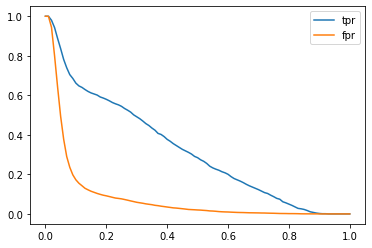

In [162]:
plt.plot(scores_data.threshold, scores_data.tpr, label = 'tpr')
plt.plot(scores_data.threshold, scores_data.fpr, label = 'fpr')
plt.legend()

## Precision vs Recall - which to choose?

If you recall (pun intended) these two terms, Precision refers to the fraction of positive predictions that are correct while recall refers to the fraction of correctly identified positive predictions. 

While it would be great to optimise both, that is often not the case and we will have to decide on which metric is better.
In this case, let us think in terms of what the bank seeks to optimise. 

Ultimately, the bank seeks to maximize its profit, and the cost of someone not opening a term deposit is more than the cost of sending an email out to a customer. Therefore, we seek to optimize the number of false positives, and therefore we should be going with precision instead of recall. 

In [163]:
scores_data['precision'] = scores_data.tp / (scores_data.tp + scores_data.fp)
scores_data['recall'] = scores_data.tp / (scores_data.tp + scores_data.fn)

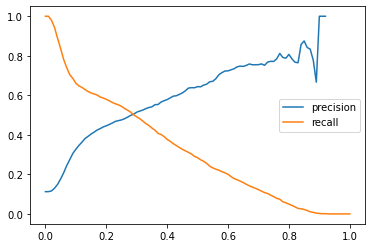

In [164]:
plt.plot(scores_data.threshold, scores_data.precision, label = 'precision')
plt.plot(scores_data.threshold, scores_data.recall, label = 'recall')
plt.legend()

Weirdly enough, at around 0.9, the precision sharply drops before it becomes goes up again and disappears after that. Let us explore why!

In [165]:
scores_data[90:]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
90,0.90,2,0,926,7310,0.002155,0.0,1.0,0.002155
91,0.91,1,0,927,7310,0.001078,0.0,1.0,0.001078
92,0.92,1,0,927,7310,0.001078,0.0,1.0,0.001078
93,0.93,0,0,928,7310,0.000000,0.0,NaN,0.000000
94,0.94,0,0,928,7310,0.000000,0.0,NaN,0.000000
95,0.95,0,0,928,7310,0.000000,0.0,NaN,0.000000
96,0.96,0,0,928,7310,0.000000,0.0,NaN,0.000000
97,0.97,0,0,928,7310,0.000000,0.0,NaN,0.000000
98,0.98,0,0,928,7310,0.000000,0.0,NaN,0.000000
99,0.99,0,0,928,7310,0.000000,0.0,NaN,0.000000


At 0.9, there is only 1 true positive. From there, the true and false positive becomes 0, and therefore the denominator of 'precision' becomes 0. Therefore, these values are undefined and therefore the above phenomena occurs! 

In [166]:
# diff = difference between precision and recall
# however we will be using the absolute value of the differences so that we find the smallest difference between both
scores_data['diff'] = abs(scores_data['precision'] - scores_data['recall'])

In [167]:
diff_min = scores_data['diff'].min()
scores_data[scores_data['diff'] == diff_min]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,diff
29,0.29,465,456,463,6854,0.501078,0.06238,0.504886,0.501078,0.003808


We can tell that 0.29 is the threshold we're looking at since it balances precision and recall the best! 

## Models against test set 

In [28]:
data_full_train, data_test = train_test_split(data, random_state = 40, test_size = 0.2, shuffle = True, stratify = data['target'])

data_full_train = data_train.reset_index(drop = True)
data_test = data_val.reset_index(drop = True)

y_full_train = data_full_train['target']
y_test = data_test['target']

del data_full_train['target']
del data_test['target']


In [38]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
xgb_params = {
    'lambda': 8.49395838886118,
    'alpha': 0.0064863432673352575,
    'colsample_bytree': 0.4,
    'subsample': 0.9,
    'learning_rate': 0.1,
    'n_estimators': 1300,
    'max_depth': 10,
    'min_child_weight': 180}

In [54]:
def train(data_full_train, y_full_train, model):
    dicts = data_full_train.to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    X_full_train = dv.fit_transform(dicts)
    
    model.fit(X_full_train, y_full_train)
    return dv, model

In [55]:
def predict(data_test, y_test, model):
    dicts = data_test.to_dict(orient = 'records')
    
    X_test = dv.transform(dicts)
    
    y_pred = model.predict_proba(X_test)[:,1]
    return y_pred

In [56]:
threshold = 0.29
dv, model = train(data_full_train, y_full_train, xgb)
y_pred = predict(data_test, dv, model)
score = roc_auc_score(y_test, y_pred) 
print("For the model: the ROC AUC score is: %.9f" % score)

[13:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For the model: the ROC AUC score is: 0.797784020


In [61]:
import pickle

output_file = 'xgbclassifier.bin' 

In [62]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, xgb), f_out)

print(f'The model is saved to {output_file}')

The model is saved to xgbclassifier.bin
